In [1]:
import bias

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
RANDOM_STATE = 1
SAMPLING_COLUMN = "num_aggl_publications_cluster"      # name of the feature / column that is used to sample the test data into equally sized data sets

NUMERIC_FEATURES = ["year", "author_seniority", "num_aggl_publications"] # -> lieber num_aggl_publications_cluster als weiteres CATEGORIAL Feature?
CATEGORIAL_FEATURES = ["author_classification_cluster", "author_journal_classification", "author_continent"]

TARGET_FEATURE = "num_aggl_single_publications" # name of the feature / clumn that will be predicted


FEATURE_PREPROCESSOR = ColumnTransformer(
    n_jobs=3,
    transformers=[
        ('num',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                #('scaler', StandardScaler())
            ]), NUMERIC_FEATURES),
        ('cat', OneHotEncoder(), CATEGORIAL_FEATURES)  # OneHotEncoder(drop="first")
    ])

MODEL = GradientBoostingRegressor()
#MODEL = GradientBoostingRegressor(max_depth=6, max_leaf_nodes=64)

PARAM_GRID = {
    'max_depth': list(range(5, 20)),
    'min_samples_leaf': list(range(5, 50, 5)),
    'n_estimators': list(range(100, 200, 10)),
    'random_state' : [RANDOM_STATE],
    'verbose' : [0]
}


PARAM_SEARCH = RandomizedSearchCV(
    MODEL,
    PARAM_GRID,
    random_state=RANDOM_STATE,
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),     # cross-validation spliter
    n_iter=20, # number of tested parameter sets
    n_jobs=6, # number of parallel processes
    scoring="r2",
    return_train_score=True,
    verbose=2)

In [3]:
data = bias.preprocess_dataset("zbmath_simple_collaboration_model_1970-2019.csv",
        categorial_rows=CATEGORIAL_FEATURES + ["author_gender", "author_classification"],
        drop_rows=["author_id", "num_aggl_collaborations", "num_aggl_collaborators"])

In [4]:
# Cluster num_aggl_publications and author_classification columns
data = bias.cluster_column(data, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")
data = bias.cluster_column(data, bias.EGONET_1_CLUSTERING, "author_classification", newcolumn="author_classification_cluster")
data = data.loc[data.year>=1970]
data.sample(4)

,year,author_gender,author_country,author_seniority,author_classification,author_journal_classification,num_aggl_publications,num_aggl_single_publications,author_continent,num_aggl_publications_cluster,author_classification_cluster
160867,1979,u,Other,5,20,FAST TRACK,4,4,,d) 4,Algebra
2162138,2000,m,US,30,20,FAST TRACK,33,19,NA,l) 30-50,Algebra
2633938,2006,f,GB,9,62,KAT 2,6,0,EU,f) 6,Probability / Statistics / Operations research
1432990,2006,u,CN,8,53,KAT 2,5,1,AS,e) 5,Differential geometry


In [5]:
male_all = data.loc[data.author_gender == 'm']
female_test = data.loc[data.author_gender == 'f']

male_all = male_all.drop(["author_gender", "author_country"], axis=1)
female_test = female_test.drop(["author_gender", "author_country"], axis=1)

## Sampling

In [6]:
# create train/test split 
male_train, male_test = bias.sampled_train_test_split(male_all, female_test, 
        SAMPLING_COLUMN, random_state=RANDOM_STATE)

a) 1
b) 2
c) 3
d) 4
e) 5
f) 6
g) 7-8
h) 9-10
i) 11-13
j) 14-18
k) 19-29
l) 30-50
m) >50


<AxesSubplot:xlabel='num_aggl_publications_cluster'>

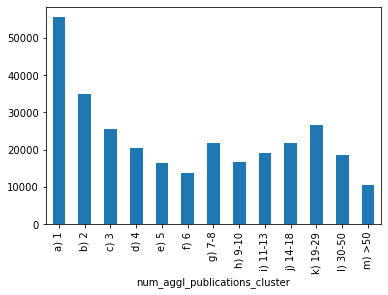

In [7]:
male_test.groupby([SAMPLING_COLUMN]).size().plot(kind="bar")

<AxesSubplot:xlabel='num_aggl_publications_cluster'>

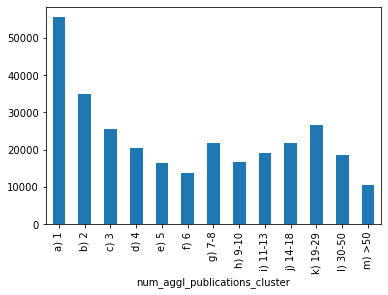

In [8]:
female_test.groupby([SAMPLING_COLUMN]).size().plot(kind="bar")

<AxesSubplot:xlabel='num_aggl_publications_cluster'>

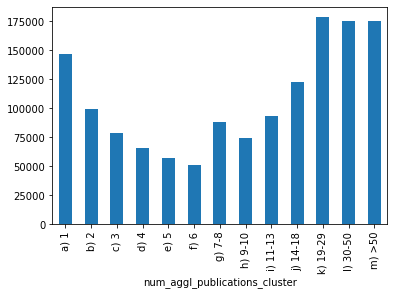

In [9]:
male_train.groupby([SAMPLING_COLUMN]).size().plot(kind="bar")

Wir sehen, dass der Anteil von Frauen mit vielen Publikationen sehr vil geringer ist als bei Männern.

In [10]:
male_train = male_train.drop("num_aggl_publications_cluster", axis=1)
male_test = male_test.drop("num_aggl_publications_cluster", axis=1)
female_test = female_test.drop("num_aggl_publications_cluster", axis=1)

In [11]:
male_train.sample(2)

,year,author_seniority,author_classification,author_journal_classification,num_aggl_publications,num_aggl_single_publications,author_continent,author_classification_cluster
2305363,1999,26,76,KAT 2,72,10,EU,PDE / Numerical / Physics
1696242,2000,6,11,FAST TRACK,6,4,AS,Number theory / Algebraic geometry


In [12]:
X_train, y_train = bias.X_y_split(male_train, TARGET_FEATURE)
X_male_test, y_male_test = bias.X_y_split(male_test, TARGET_FEATURE)
X_female_test, y_female_test = bias.X_y_split(female_test, TARGET_FEATURE)

In [13]:
X_train_t = FEATURE_PREPROCESSOR.fit_transform(X_train)
X_male_test_t = FEATURE_PREPROCESSOR.transform(X_male_test)
X_female_test_t = FEATURE_PREPROCESSOR.transform(X_female_test)

feature_names = NUMERIC_FEATURES+list(FEATURE_PREPROCESSOR.transformers_[1][1].get_feature_names())

In [14]:
Df = pd.DataFrame

if FEATURE_PREPROCESSOR.sparse_output_:
    Df = pd.DataFrame.sparse.from_spmatrix

X_train_t = Df(X_train_t, columns=feature_names, index=X_train.index)
X_male_test_t = Df(X_male_test_t, columns=feature_names, index=X_male_test.index)
X_female_test_t = Df(X_female_test_t, columns=feature_names, index=X_female_test.index)

## Hyperparameter Search

In [ ]:
PARAM_SEARCH.fit(X_train_t, y_train)

hparam_results = pd.DataFrame(PARAM_SEARCH.cv_results_)
best_model = PARAM_SEARCH.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
print("Best hyperparameters found:\n  {}".format(PARAM_SEARCH.best_params_))

hparam_results.sort_values("rank_test_score")

In [ ]:
hparam_results[["param_n_estimators", "param_min_samples_leaf", 
                "param_max_depth","mean_train_score", "mean_test_score"]].sort_values(by="mean_test_score")

## Evaluate model

In [ ]:
train_result, test_results = bias.single_train_multi_test_eval(
        best_model, X_train_t, y_train, copy=["year", "author_seniority", "num_aggl_publications"], fit=False,
        female=(X_female_test_t, y_female_test), male=(X_male_test_t, y_male_test))

In [20]:
# Add additional evaluation metrics
for res in [train_result] + list(test_results.values()):
    res["y/y_hat"] = res["y"]/res["y_hat"]
    res["y_hat-y"] = res["y_hat"]-res["y"]
    res["y_hat+y"] = res["y_hat"]+res["y"]
    res["(y_hat-y)/(y_hat+y)"] = res["y_hat-y"]/res["y_hat+y"]
    res["y_perc"] = res["y"]*100 / res["num_aggl_publications"]
    res["y_hat_perc"] = res["y_hat"]*100 / res["num_aggl_publications"]
    res.drop(["single_publication_perc"], axis=1)
    res = bias.cluster_column(res, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")

KeyError: "['single_publication_perc'] not found in axis"

In [28]:
train_result["y_perc"] = train_result["y"] / train_result["num_aggl_publications"]
train_result["y_hat_perc"] = train_result["y_hat"] / train_result["num_aggl_publications"]


print("Male mean y_perc", np.mean(train_result["y_perc"]))
print("Male mean y_hat_perc", np.mean(train_result["y_hat_perc"]))
print(np.mean(train_result["y_hat_perc"]) - np.mean(train_result["y_perc"]))

Male mean y_perc 0.41123198829154184
Male mean y_hat_perc 0.411510095665677
0.0002781073741351392


In [ ]:
test_results["female"]["y_perc"] = test_results["female"]["y"] / test_results["female"]["num_aggl_publications"]
test_results["female"]["y_hat_perc"] = test_results["female"]["y_hat"] / test_results["female"]["num_aggl_publications"]

test_results["male"]["y_perc"] = test_results["male"]["y"] / test_results["male"]["num_aggl_publications"]
test_results["male"]["y_hat_perc"] = test_results["male"]["y_hat"] / test_results["male"]["num_aggl_publications"]



print("Female mean y_perc", np.mean(test_results["female"]["y_perc"]))
print("Female mean y_hat_perc", np.mean(test_results["female"]["y_hat_perc"]))
print(np.mean(test_results["female"]["y_hat_perc"]) - np.mean(test_results["female"]["y_perc"]))

print("Male mean y_perc", np.mean(test_results["male"]["y_perc"]))
print("Male mean y_hat_perc", np.mean(test_results["male"]["y_hat_perc"]))

In [30]:
from scipy.stats import wasserstein_distance

print("WD y", wasserstein_distance(test_results["male"]["y"], test_results["female"]["y"]))
print("WD y_hat", wasserstein_distance(test_results["male"]["y_hat"], test_results["female"]["y_hat"]))

print("WD y -> h_hat female", wasserstein_distance(test_results["female"]["y"], test_results["female"]["y_hat"]))
print("WD y -> h_hat male", wasserstein_distance(test_results["male"]["y"], test_results["male"]["y_hat"]))

WD y 1.3945331823811076
WD y_hat 0.8391907140171082
WD y -> h_hat female 0.7625626043757058
WD y -> h_hat male 0.5787286325475434


In [ ]:
#test_results["female"].to_pickle("mb_best_results_single_female.pkl")
#test_results["male"].to_pickle("mb_best_results_single_male.pkl")

## Feature importance in trained model

In [ ]:
try:
    list(map(print, sorted(zip(feature_names, best_model.feature_importances_), key=lambda t: t[1], reverse=True)))
except AttributeError:
    list(map(print, sorted(zip(feature_names, best_model.coef_), key=lambda t: abs(t[1]), reverse=True)))

## Comparison of model prediction metrics

In [ ]:
print(bias.compare_mb_results(train_result, test_results))

## Prediction accuracy plots

In [ ]:
bias.plot_mb_test_results(test_results, SAMPLING_COLUMN, "y/y_hat",
        axis_callbacks=[lambda x: x.set_ylim([0, 2]), lambda x: x.hlines(1, 0, 55, color="black")]).show()

bias.plot_mb_test_results(test_results, SAMPLING_COLUMN, "y/y_hat", aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 2]), lambda x: x.hlines(1, 0, 55, color="black")]).show()

In [ ]:
bias.plot_mb_test_results(test_results, SAMPLING_COLUMN, "y_hat-y",
        axis_callbacks=[lambda x: x.set_ylim([-2, 2]), lambda x: x.hlines(0, 0, 55, color="black")]).show()

bias.plot_mb_test_results(test_results, SAMPLING_COLUMN, "y_hat-y", aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([-2, 2]), lambda x: x.hlines(0, 0, 55, color="black")]).show()

In [ ]:
bias.plot_mb_test_results(test_results, SAMPLING_COLUMN, "y_hat+y",
        axis_callbacks=[lambda x: x.set_ylim([0, 10]), lambda x: x.hlines(0, 0, 55, color="black")]).show()

bias.plot_mb_test_results(test_results, SAMPLING_COLUMN, "y_hat+y", aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 10]), lambda x: x.hlines(0, 0, 55, color="black")]).show()

In [ ]:
bias.plot_mb_test_results(test_results, SAMPLING_COLUMN, "(y_hat-y)/(y_hat+y)",
        axis_callbacks=[lambda x: x.set_ylim([-0.5, 1]), lambda x: x.hlines(0, 0, 55, color="black")]).show()

bias.plot_mb_test_results(test_results, SAMPLING_COLUMN, "(y_hat-y)/(y_hat+y)", aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([-0.5, 1]), lambda x: x.hlines(0, 0, 55, color="black")]).show()

In [ ]:
sns.scatterplot(x="y_hat-y", y="y_hat+y", data=test_results["female"])

In [ ]:
sns.scatterplot(x="y_hat-y", y="y_hat+y", data=test_results["male"])

In [ ]:
sns.scatterplot(x="y_hat-y", y="author_seniority", data=test_results["male"])

In [ ]:
sns.scatterplot(x="y_hat-y", y="year", data=test_results["male"])

## Graphical distibution of predictions by document publication year

In [ ]:
bias.plot_mb_test_results(test_results, "year", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results, "year"), "year", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()


bias.plot_mb_test_results(test_results, "year", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results, "year"), "year", ["mean_female", "mean_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

In [ ]:
bias.plot_mb_test_results(test_results, "year", ["single_publication_perc"],
        axis_callbacks=[lambda x: x.set_xlim([1970, 2020])]).show()

#bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results, "year"), "year", ["mean_female", "mean_male"],
#        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

## Graphical distibution of predictions by author seniority

In [ ]:
bias.plot_mb_test_results(test_results, "author_seniority", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results, "author_seniority"), "author_seniority", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()


bias.plot_mb_test_results(test_results, "author_seniority", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results, "author_seniority"), "author_seniority", ["mean_female", "mean_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()

In [ ]:
bias.plot_mb_test_results(test_results, "author_seniority", ["single_publication_perc"],
        axis_callbacks=[lambda x: x.set_xlim([0, 60])]).show()

## Graphical distibution of predictions by (clustered) number of publications per author

In [ ]:
bias.plot_mb_test_results(test_results, "num_aggl_publications", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results, "num_aggl_publications"), "num_aggl_publications", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(test_results, "num_aggl_publications_cluster", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results, "num_aggl_publications_cluster"), "num_aggl_publications_cluster", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()


bias.plot_mb_test_results(test_results, "num_aggl_publications", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results, "num_aggl_publications"), "num_aggl_publications", ["mean_female", "mean_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(test_results, "num_aggl_publications_cluster", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results, "num_aggl_publications_cluster"), "num_aggl_publications_cluster", ["mean_female", "mean_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

In [ ]:
bias.plot_mb_test_results(test_results, "num_aggl_publications", ["single_publication_perc"],
        axis_callbacks=[]).show()

bias.plot_mb_test_results(test_results, "num_aggl_publications_cluster", ["single_publication_perc"],
        axis_callbacks=[]).show()

## Manual comparison with worst model

In [ ]:
MODEL_w = GradientBoostingRegressor(min_samples_leaf=30, n_estimators=140, max_depth=6)

train_result_w, test_results_w = bias.single_train_multi_test_eval(
        MODEL_w, X_train_t, y_train, copy=["year", "author_seniority", "num_aggl_publications"],
        female=(X_female_test_t, y_female_test), male=(X_male_test_t, y_male_test))

In [ ]:
# Add additional evaluation metrics
for res in [train_result_w] + list(test_results_w.values()):
    res["y/y_hat"] = res["y"]/res["y_hat"]
    res["y_hat-y"] = res["y_hat"]-res["y"]
    res["y_hat+y"] = res["y_hat"]+res["y"]
    res["(y_hat-y)/(y_hat+y)"] = res["y_hat-y"]/res["y_hat+y"]
    res["y_perc"] = res["y"]*100 / res["num_aggl_publications"]
    res["y_hat_perc"] = res["y_hat"]*100 / res["num_aggl_publications"]
    res = bias.cluster_column(res, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")

In [ ]:
try:
    list(map(print, sorted(zip(feature_names, MODEL_w.feature_importances_), key=lambda t: t[1], reverse=True)))
except AttributeError:
    list(map(print, sorted(zip(feature_names, MODEL_w.coef_), key=lambda t: abs(t[1]), reverse=True)))

print(bias.compare_mb_results(train_result_w, test_results_w))

bias.plot_mb_test_results(test_results_w, SAMPLING_COLUMN, "y/y_hat",
        axis_callbacks=[lambda x: x.set_ylim([0, 2]), lambda x: x.hlines(1, 0, 55, color="black")]).show()

## Manual comparison with less overfitting and performing models

In [ ]:
MODEL_1 = GradientBoostingRegressor(min_samples_leaf=10, n_estimators=190, max_depth=11, random_state=RANDOM_STATE)
# mean_train_score  mean_test_score
# 0.798202          0.752738


train_result_1, test_results_1 = bias.single_train_multi_test_eval(
        MODEL_1, X_train_t, y_train, copy=["year", "author_seniority", "num_aggl_publications"],
        female=(X_female_test_t, y_female_test), male=(X_male_test_t, y_male_test))

In [ ]:
# Add additional evaluation metrics
for res in [train_result_1] + list(test_results_1.values()):
    res["y/y_hat"] = res["y"]/res["y_hat"]
    res["y_hat-y"] = res["y_hat"]-res["y"]
    res["y_hat+y"] = res["y_hat"]+res["y"]
    res["(y_hat-y)/(y_hat+y)"] = res["y_hat-y"]/res["y_hat+y"]
    res["y_perc"] = res["y"]*100 / res["num_aggl_publications"]
    res["y_hat_perc"] = res["y_hat"]*100 / res["num_aggl_publications"]
    res.drop(["single_publication_perc"], axis=1)
    res = bias.cluster_column(res, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")

In [ ]:
bias.plot_mb_test_results(test_results, "year", ["single_publication_perc"],
        axis_callbacks=[lambda x: x.set_xlim([1970, 2020])]).show()

bias.plot_mb_test_results(test_results, "author_seniority", ["single_publication_perc"],
        axis_callbacks=[lambda x: x.set_xlim([0, 60])]).show()

bias.plot_mb_test_results(test_results_1, "num_aggl_publications", ["single_publication_perc"],
        axis_callbacks=[lambda x: x.set_xlim([0, 200])]).show()

bias.plot_mb_test_results(test_results_1, "num_aggl_publications_cluster", ["single_publication_perc"],
        axis_callbacks=[]).show()

In [ ]:
try:
    list(map(print, sorted(zip(feature_names, MODEL_1.feature_importances_), key=lambda t: t[1], reverse=True)))
except AttributeError:
    list(map(print, sorted(zip(feature_names, MODEL_1.coef_), key=lambda t: abs(t[1]), reverse=True)))


## Scores
    
print(bias.compare_mb_results(train_result_1, test_results_1))


## Plots

bias.plot_mb_test_results(test_results_1, SAMPLING_COLUMN, "y/y_hat",
        axis_callbacks=[lambda x: x.set_ylim([0, 2]), lambda x: x.hlines(1, 0, 55, color="black")]).show()

bias.plot_mb_test_results(test_results_1, SAMPLING_COLUMN, "y/y_hat", aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 2]), lambda x: x.hlines(1, 0, 55, color="black")]).show()



bias.plot_mb_test_results(test_results_1, "year", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_1, "year"), "year", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

bias.plot_mb_test_results(test_results_1, "year", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_1, "year"), "year", ["median_female", "median_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()


bias.plot_mb_test_results(test_results_1, "author_seniority", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_1, "author_seniority"), "author_seniority", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()

bias.plot_mb_test_results(test_results_1, "author_seniority", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_1, "author_seniority"), "author_seniority", ["median_female", "median_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()



bias.plot_mb_test_results(test_results_1, "num_aggl_publications", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_1, "num_aggl_publications"), "num_aggl_publications", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(test_results_1, "num_aggl_publications_cluster", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_1, "num_aggl_publications_cluster"), "num_aggl_publications_cluster", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

bias.plot_mb_test_results(test_results_1, "num_aggl_publications", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_1, "num_aggl_publications"), "num_aggl_publications", ["median_female", "median_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(test_results_1, "num_aggl_publications_cluster", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_1, "num_aggl_publications_cluster"), "num_aggl_publications_cluster", ["median_female", "median_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

In [ ]:
MODEL_2 = GradientBoostingRegressor(min_samples_leaf=10, n_estimators=160, max_depth=15, random_state=RANDOM_STATE)
# mean_train_score  mean_test_score
# 0.821920          0.739097


train_result_2, test_results_2 = bias.single_train_multi_test_eval(
        MODEL_2, X_train_t, y_train, copy=["year", "author_seniority", "num_aggl_publications"],
        female=(X_female_test_t, y_female_test), male=(X_male_test_t, y_male_test))

# Add additional evaluation metrics
for res in [train_result_2] + list(test_results_2.values()):
    res["y/y_hat"] = res["y"]/res["y_hat"]
    res["y_hat-y"] = res["y_hat"]-res["y"]
    res["y_hat+y"] = res["y_hat"]+res["y"]
    res["(y_hat-y)/(y_hat+y)"] = res["y_hat-y"]/res["y_hat+y"]
    res = bias.cluster_column(res, bias.PUBLICATION_COUNT_CLUSTERING, "num_aggl_publications", newcolumn="num_aggl_publications_cluster")

In [ ]:
try:
    list(map(print, sorted(zip(feature_names, MODEL_2.feature_importances_), key=lambda t: t[1], reverse=True)))
except AttributeError:
    list(map(print, sorted(zip(feature_names, MODEL_2.coef_), key=lambda t: abs(t[1]), reverse=True)))


## Scores
    
print(bias.compare_mb_results(train_result_2, test_results_2))


## Plots

bias.plot_mb_test_results(test_results_2, SAMPLING_COLUMN, "y/y_hat",
        axis_callbacks=[lambda x: x.set_ylim([0, 2]), lambda x: x.hlines(1, 0, 55, color="black")]).show()

bias.plot_mb_test_results(test_results_2, SAMPLING_COLUMN, "y/y_hat", aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 2]), lambda x: x.hlines(1, 0, 55, color="black")]).show()



bias.plot_mb_test_results(test_results_2, "year", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_2, "year"), "year", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

bias.plot_mb_test_results(test_results_2, "year", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_2, "year"), "year", ["median_female", "median_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 16]), lambda x: x.set_xlim([1970, 2020])]).show()


bias.plot_mb_test_results(test_results_2, "author_seniority", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_2, "author_seniority"), "author_seniority", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()

bias.plot_mb_test_results(test_results_2, "author_seniority", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_2, "author_seniority"), "author_seniority", ["median_female", "median_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 35]), lambda x: x.set_xlim([0, 50])]).show()



bias.plot_mb_test_results(test_results_2, "num_aggl_publications", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_2, "num_aggl_publications"), "num_aggl_publications", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(test_results_2, "num_aggl_publications_cluster", ["y_hat", "y"],
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_2, "num_aggl_publications_cluster"), "num_aggl_publications_cluster", ["mean_female", "mean_male"],
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

bias.plot_mb_test_results(test_results_2, "num_aggl_publications", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_2, "num_aggl_publications"), "num_aggl_publications", ["median_female", "median_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 50]), lambda x: x.set_xlim([0, 150])]).show()

bias.plot_mb_test_results(test_results_2, "num_aggl_publications_cluster", ["y_hat", "y"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()

bias.plot_mb_test_results(bias.combine_mb_gender_predictions(test_results_2, "num_aggl_publications_cluster"), "num_aggl_publications_cluster", ["median_female", "median_male"], aggregator="median",
        axis_callbacks=[lambda x: x.set_ylim([0, 30])]).show()